# Age Classifier

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from collections import defaultdict
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

## 0. Setup

In [2]:
path = '../../data/face_age'
width = 48
height = 48
train = True
export = False
model_name = ''

## 1. Data Preparation

In [3]:
def load_image(filename: str, size: tuple[int, int]) -> np.array:
    """Loads and resizes the image."""
    image = Image.open(filename).convert('L')
    resized_image = image.resize(size)
    return np.array(resized_image)

In [4]:
images = defaultdict()

for subfolder in os.listdir(path):
    images_per_folder = glob.glob(f'{path}/{subfolder}/*.png')
    number_of_images = len(images_per_folder)
    key = int(subfolder.lstrip('0'))
    tmp = []

    for filename in images_per_folder:
        image = load_image(filename, size=(width, height))
        tmp.append(image)

    images[key] = tmp
    tmp = []

In [5]:
child = []
young_adult = []
adult = []
senior = []

for key, value in images.items():
    if key <= 16:
        child += value
    elif 16 < key <= 30:
        young_adult += value
    elif 30 < key <= 60:
        adult += value
    else:
        senior += value

data = defaultdict()
data['child'] = child
data['young_adult'] = young_adult
data['adult'] = adult
data['senior'] = senior

In [6]:
X = np.array([])
y = np.array([])
labels = {
    'child': 0,
    'young_adult': 1,
    'adult': 2,
    'senior': 3,
}

for key, value in data.items():
    n = len(value)
    X = np.append(X, value)
    y = np.append(y, [labels[key]] * n)

X = X.reshape(-1, width, height, 1)

In [7]:
test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=test_size, 
                                                  random_state=42)

In [8]:
shift = 0.1
datagen = ImageDataGenerator(rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=shift,
                             width_shift_range=shift,
                             shear_range=shift,
                             zoom_range=shift)

datagen.fit(x_train)

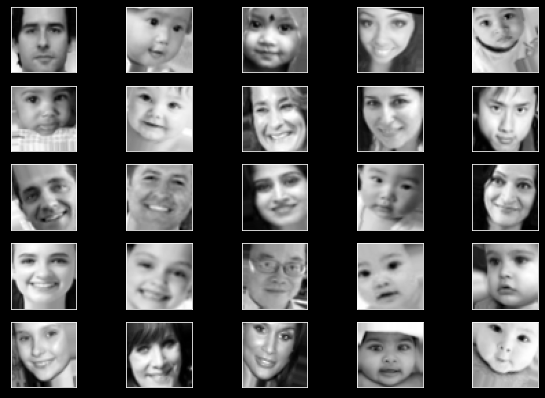

In [9]:
it = datagen.flow(x_train, y_train, batch_size=1)
plt.figure(figsize=(10, 7))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(it.next()[0][0], cmap='gray')

plt.show()

## 2. Model Training

In [10]:
epochs = 200
batch_size = 64

print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

X_train shape: (7822, 48, 48, 1)
Y_train shape: (7822,)
X_test shape: (978, 48, 48, 1)
Y_test shape: (978,)
X_val shape: (978, 48, 48, 1)
Y_val shape: (978,)


In [11]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(height, width, 1)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax'),
])

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0

In [12]:
train_progress = None

if train:
    early_stopping = EarlyStopping(patience=20,
                                   verbose=2,
                                   restore_best_weights=True)
    
    train_progress = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
                               epochs=epochs, 
                               steps_per_epoch=len(x_train) // batch_size, 
                               validation_data=(x_val, y_val), 
                               verbose=2,
                               callbacks=[early_stopping])
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

Epoch 1/200
122/122 - 11s - loss: 1.3122 - accuracy: 0.4189 - val_loss: 5.4026 - val_accuracy: 0.4039 - 11s/epoch - 89ms/step
Epoch 2/200
122/122 - 6s - loss: 1.1777 - accuracy: 0.4745 - val_loss: 13.3352 - val_accuracy: 0.4039 - 6s/epoch - 46ms/step
Epoch 3/200
122/122 - 6s - loss: 1.0815 - accuracy: 0.5295 - val_loss: 1.4038 - val_accuracy: 0.2597 - 6s/epoch - 46ms/step
Epoch 4/200
122/122 - 6s - loss: 1.0795 - accuracy: 0.5287 - val_loss: 1.1221 - val_accuracy: 0.4908 - 6s/epoch - 46ms/step
Epoch 5/200
122/122 - 6s - loss: 1.0586 - accuracy: 0.5415 - val_loss: 1.1132 - val_accuracy: 0.5542 - 6s/epoch - 46ms/step
Epoch 6/200
122/122 - 6s - loss: 1.0370 - accuracy: 0.5519 - val_loss: 1.0664 - val_accuracy: 0.5235 - 6s/epoch - 47ms/step
Epoch 7/200
122/122 - 6s - loss: 1.0136 - accuracy: 0.5558 - val_loss: 0.9237 - val_accuracy: 0.6053 - 6s/epoch - 47ms/step
Epoch 8/200
122/122 - 6s - loss: 0.9830 - accuracy: 0.5714 - val_loss: 2.5083 - val_accuracy: 0.4468 - 6s/epoch - 47ms/step
Epoch

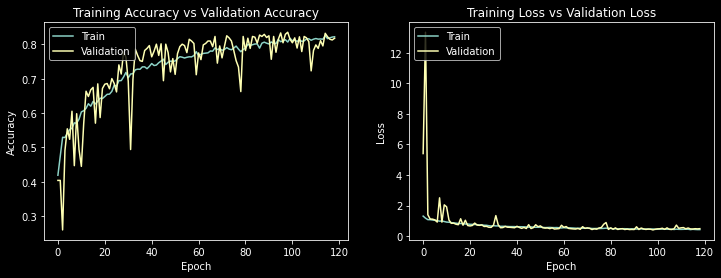

In [13]:
if train_progress:
    fig, ax = plt.subplots(1, 2)
    train_acc = train_progress.history['accuracy']
    train_loss = train_progress.history['loss']
    fig.set_size_inches(12, 4)

    ax[0].plot(train_progress.history['accuracy'])
    ax[0].plot(train_progress.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(train_progress.history['loss'])
    ax[1].plot(train_progress.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [14]:
if export:
    model.save(f'../models/{model_name}.h5')